# Rabi splitting with TLS

Here, we demonstrate the socket-free TLS workflow using the `maxwelllink.SingleModeSimulation` electromagnetic solver. By resonantly coupling one classical cavity mode to a two-level system (TLS), we aim to monitor the cavity coordinate and verify the expected Rabi splitting in the frequency domain.

## 1. Defining Molecule

We first create a `Molecule` instance using the non-socket mode, i.e., we directly initialize the TLS within the `Molecule` class:

In [1]:
import numpy as np
import maxwelllink as mxl

frequency_au = 0.242
mu12 = 187

molecule = mxl.Molecule(
    driver="tls",
    driver_kwargs={
        "omega": frequency_au,
        "mu12": mu12,
        "orientation": 2,
        "pe_initial": 0e-3,
    }
)

[Init Molecule] Operating in non-socket mode, using driver: tls


## 2. Defining the single mode cavity

Then, we create a `SingleModeSimulation` instance which defines the parameters for a single harmonic oscillator. The pre-defined `molecule` is also attached to this class for coupled light-matter simulations.

This single-mode cavity obeys the following equations of motion:

$$
\ddot{q}_{\rm c} = -\omega_{\rm c}^{2}\, q_c - \varepsilon \sum_i \mu_i - \gamma_c\, p_{\rm c} + D(t),
$$

where the effective electric field of this cavity mode is

$$
E(t) = -\varepsilon q_{\rm c}(t) .
$$

Here, $\varepsilon = \frac{\omega_{\rm c}}{\sqrt{\epsilon_0 V}}$ is the **coupling strength**, and the sum runs over the selected molecular axis of all molecules attaced to the ``SingleModeSimulation`` class. All quantities are in **atomic units**. Dipole self-energy is excluded in the calculation of the effective electric field $E(t)$.


In [2]:

coupling_strength = 5e-5
dt_au = 1e-1
damping_au = 0e-4
total_steps = 40960

sim = mxl.SingleModeSimulation(
    molecules=[molecule],
    frequency_au=frequency_au,
    coupling_strength=coupling_strength,
    damping_au=damping_au,
    coupling_axis="z",
    drive=0.0,
    dt_au=dt_au,
    qc_initial=[0, 0, 1e-5],
    record_history=True,
    # excluding dipole self-energy term for TLS model
    include_dse=False,
)

print(
    f"Configured SingleModeSimulation with omega_c = {frequency_au:.3f} a.u. "
    f"and g = {coupling_strength:.3f} a.u."
)

sim.run(steps=total_steps)

init TLSModel with dt = 0.100000 a.u., molecule ID = 0
Configured SingleModeSimulation with omega_c = 0.242 a.u. and g = 0.000 a.u.
[SingleModeCavity] Completed 1000/40960 [2.4%] steps, time/step: 1.68e-04 seconds, remaining time: 6.71 seconds.
[SingleModeCavity] Completed 2000/40960 [4.9%] steps, time/step: 1.19e-04 seconds, remaining time: 5.59 seconds.
[SingleModeCavity] Completed 3000/40960 [7.3%] steps, time/step: 1.11e-04 seconds, remaining time: 5.04 seconds.
[SingleModeCavity] Completed 4000/40960 [9.8%] steps, time/step: 1.13e-04 seconds, remaining time: 4.72 seconds.
[SingleModeCavity] Completed 5000/40960 [12.2%] steps, time/step: 1.16e-04 seconds, remaining time: 4.51 seconds.
[SingleModeCavity] Completed 6000/40960 [14.6%] steps, time/step: 1.16e-04 seconds, remaining time: 4.33 seconds.
[SingleModeCavity] Completed 7000/40960 [17.1%] steps, time/step: 1.14e-04 seconds, remaining time: 4.16 seconds.
[SingleModeCavity] Completed 8000/40960 [19.5%] steps, time/step: 1.20e-04

## 3. Retrieve simulation observables

After the simulation, we can retrieve the TLS trajectory from `molecule.additional_data_history` together with the cavity coordinate `q_c(t)` stored directly by `SingleModeSimulation`.

In [3]:
population = np.array([entry["Pe"] for entry in molecule.additional_data_history])
tls_time_au = np.array([entry["time_au"] for entry in molecule.additional_data_history])

qc_history = np.array(sim.qc_history)[:, 2]  # z-component
energy_history = np.array(sim.energy_history)
time_history = np.array(sim.time_history)

print(
    f"Collected {population.size} TLS samples and {qc_history.size} cavity samples."
)

Collected 40960 TLS samples and 40960 cavity samples.


## 4. Inspect time-domain Rabi oscillations

Because the TLS is at resonance with the classical cavity mode, Rabi oscillations can be observed for this coupled system.



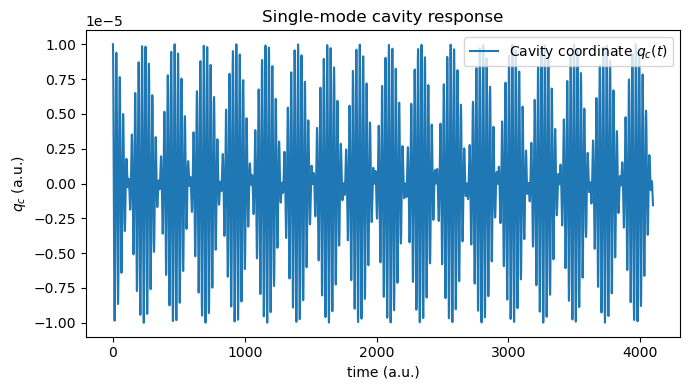

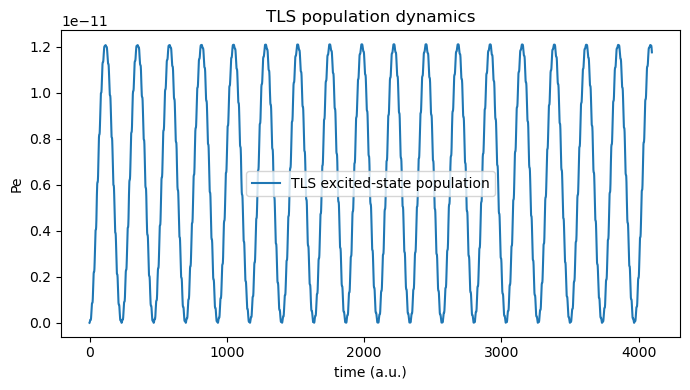

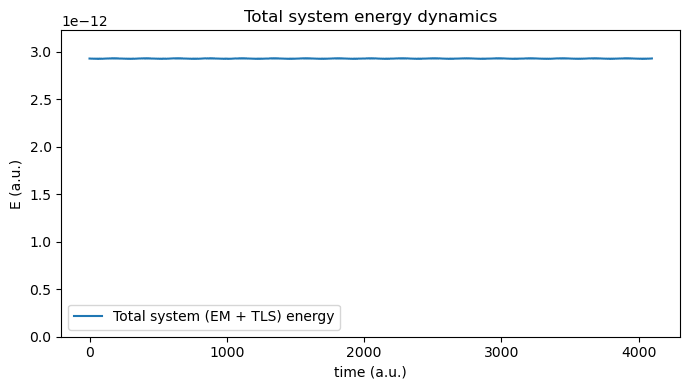

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
plt.plot(time_history, qc_history, label="Cavity coordinate $q_c(t)$")
plt.xlabel("time (a.u.)")
plt.ylabel("$q_c$ (a.u.)")
plt.title("Single-mode cavity response")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(tls_time_au, population, label="TLS excited-state population")
plt.xlabel("time (a.u.)")
plt.ylabel("Pe")
plt.title("TLS population dynamics")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(tls_time_au, energy_history, label="Total system (EM + TLS) energy")
plt.xlabel("time (a.u.)")
plt.ylabel("E (a.u.)")
plt.title("Total system energy dynamics")
plt.ylim(0, np.max(np.array(energy_history))*1.1)
plt.legend()
plt.tight_layout()
plt.show()

## 6. Fourier analysis of the cavity coordinate

Analytically, for this simple model system, we can calculate the assoicated Rabi splitting under the rotating wave approximation as:

$$
\Delta_{\rm{Rabi}} = \varepsilon \mu_{12} \sqrt{\frac{2}{\hbar \omega }}
$$

We can of course obtain the numerical Rabi splitting by Fourier transforming the cavity coordinate dynamics, which can be compared with the above analytical solution.

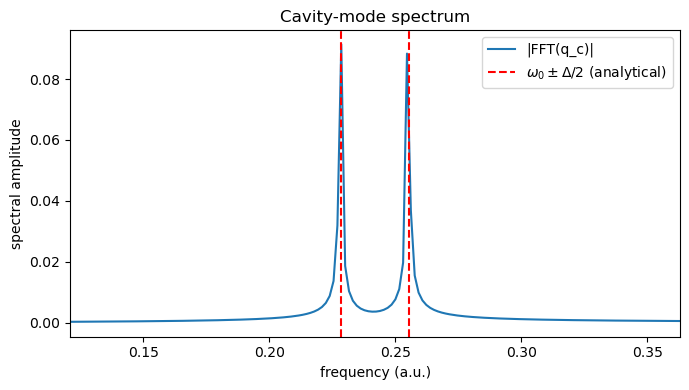

In [5]:
signal = qc_history - np.mean(qc_history)
if signal.size == 0:
    raise RuntimeError("No cavity data recorded; ensure the simulation was executed above.")

dt_sim = np.mean(np.diff(time_history)) if time_history.size > 1 else dt_au
fft_vals = np.fft.rfft(signal)
freqs = np.fft.rfftfreq(signal.size, d=dt_sim) * 2.0 * np.pi
spectrum = np.abs(fft_vals)

# analytical Rabi splitting
rabi_splitting = coupling_strength * mu12 * (2.0/frequency_au)**0.5

expected_peaks = np.array([
    frequency_au - rabi_splitting/2.0,
    frequency_au + rabi_splitting/2.0,
])

plt.figure(figsize=(7, 4))
plt.plot(freqs, spectrum, label="|FFT(q_c)|")
for idx, freq in enumerate(expected_peaks):
    label = r"$\omega_0 \pm \Delta/2$ (analytical)" if idx == 0 else None
    plt.axvline(freq, color="red", linestyle="--", label=label)
plt.xlabel("frequency (a.u.)")
plt.xlim(frequency_au*0.5, frequency_au*1.5)
plt.ylabel("spectral amplitude")
plt.title("Cavity-mode spectrum")
plt.legend()
plt.tight_layout()
plt.show()